***Vorlesung 'Syntax natürlicher Sprachen', WS 2020/21***

---
# Übung 10 (Lösung)

In [1]:
import nltk
from nltk.featstruct import FeatStruct
from nltk.featstruct import Feature, UnificationFailure
import itertools
from exercises_10 import *
from questions import aufgabe

---
## Aufgabe 1: Unifikation I

#### Gegeben seien folgende Merkmalstrukturen:

In [2]:
f1 = FeatStruct(
    '[Vorname=Max, Nachname=Mustermann,' + 
    'Privat=[Strasse=Hauptstrasse, Ort=[Muenchen]]]'
)
f2 = FeatStruct(
    '[Arbeit=[Strasse="Oettingenstrasse", Ort=(1)["Muenchen"]],' +
    'Privat=[Ort->(1)]]')
f3 = FeatStruct(
    '[Strasse="Hauptstrasse"]'
)
f4 = FeatStruct(
    '[Privat=[Strasse="Hauptstrasse", Ort=["Passau"]]]'
)

#### Unifizieren Sie:
- f1 mit f2
- f2 mit f4

#### Kontrollieren sie am Ende ihre Lösung zuerst mit Hilfe der interaktiven Fragen und überdenken Sie diese gegebenenfalls.

#### Mit der Ausführung der unteren beiden print-Statements können Sie abschließend die Lösung einsehen.

In [3]:
aufgabe(blatt10_1)

SingleChoice(children=(HTML(value='<h4 style="font-size:14px;">Unifizieren f1 und f2?</h4>', layout=Layout(jus…

SingleChoice(children=(HTML(value='<h4 style="font-size:14px;">Unifizieren f2 und f4?</h4>', layout=Layout(jus…

In [4]:
print(f1.unify(f2).__repr__())

[Arbeit=[Ort=(1)['Muenchen'], Strasse='Oettingenstrasse'], Nachname='Mustermann', Privat=[Ort->(1), Strasse='Hauptstrasse'], Vorname='Max']


In [5]:
print(f2.unify(f4).__repr__())

None


---
## Aufgabe 2:  Typhierarchie im NLTK

#### Gegeben sei folgende Typhierarchie:

$$\bot \sqsubseteq \text{Genitiv}$$
$$\bot \sqsubseteq \text{nicht-Genitiv}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Nominativ-Akkusativ}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Dativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Nominativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Akkusativ}$$

#### Implementieren Sie mithilfe der Klasse `HierarchicalFeature`, die Sie mit der folgenden Zelle importieren können, ein Feature `CASE`, das der vorgegebenen Typhierarchie entspricht.


In [6]:
TYPE = nltk.featstruct.TYPE


def check_sanity_constraints(th):
    for type1, type2 in itertools.product(th, th):
        if type1 in th[type2] and type2 in th[type1]:
            if type1 != type2:
                raise ValueError(
                    "The type hierarchy is not antisymmetric! " +
                    "{} subsumes {} and vice versa!".format(
                        type1, type2
                    )
                )


def refl_trans_closure(type_hierarchy):
    # make everything a set
    # and compute reflexive closure
    closure = {}
    for t in type_hierarchy:
        closure[t] = set(type_hierarchy[t])
        closure[t].add(t)

    # compute transitive closure
    still_changes = True
    while still_changes:
        still_changes = False
        for x in closure:
            new_for_x = set()
            for y in closure[x]:
                for z in closure[y]:
                    new_for_x.add(z)
            len_before = len(closure[x])
            closure[x].update(new_for_x)
            still_changes |= len(closure[x]) > len_before

    return closure


class HierarchicalFeature(Feature):
    def __init__(self, name, type_hierarchy, **kwargs):
        super(HierarchicalFeature, self).__init__(name, **kwargs)

        self.hierarchy = refl_trans_closure(type_hierarchy)
        check_sanity_constraints(self.hierarchy)

    def unify_base_values(self, fval1, fval2, bindings):
        candidates = self.hierarchy[fval1].intersection(self.hierarchy[fval2])
        score = {t: 0 for t in candidates}
        for type1, type2 in itertools.product(candidates, candidates):
            if type1 in self.hierarchy[type2]:
                score[type1] += 1

        return min(candidates, key=score.__getitem__, default=UnificationFailure)



#### Nutzen Sie dieses Feature dann, um Übergenerierung in folgender Grammatik zu vermeiden:

In [7]:
grammar = """
S -> NP[*CASE*=Nom] VP
NP[*CASE*=?x] -> DET[*CASE*=?x,GEN=?y] NOM[*CASE*=?z,GEN=?y]
NOM[*CASE*=?x,GEN=?y] -> N[*CASE*=?x,GEN=?y] NP[*CASE*=Gen] | N[*CASE*=?x,GEN=?y]
VP -> V

V -> "schläft"
DET[GEN=mask,*CASE*=Nom] -> "der"
DET[GEN=mask,*CASE*=Gen] -> "des"
DET[GEN=fem,*CASE*=NomAkk] -> "die"
DET[GEN=fem,*CASE*=Gen] -> "der"
DET[GEN=fem,*CASE*=Dat] -> "der"
DET[GEN=neut,*CASE*=NomAkk] -> "das"
DET[GEN=neut,*CASE*=Gen] -> "des"

N[GEN=mask,*CASE*=nonGen] -> "Mann"
N[GEN=mask,*CASE*=Gen] -> "Mannes"
N[GEN=fem] -> "Frau"
N[GEN=neut,*CASE*=nonGen] -> "Kind"
N[GEN=neut,*CASE*=Gen] -> "Kindes"
"""

#### Hier muss die Typhierarchie in Form eines `Dictionary` definiert werden:

In [8]:
type_hierarchy = {
    "nonGen": ["NomAkk", "Dat"],
    "NomAkk": ["Nom", "Akk"],
    "Dat": [],
    "Akk": [],
    "Gen": [],
    "Nom": []
}

In [9]:
CASE = HierarchicalFeature("CASE", type_hierarchy)
compiled_grammar = nltk.grammar.FeatureGrammar.fromstring(
    grammar, features=(CASE, TYPE)
)
parser = nltk.FeatureEarleyChartParser(compiled_grammar)

#### Folgendes sollte funktionieren:

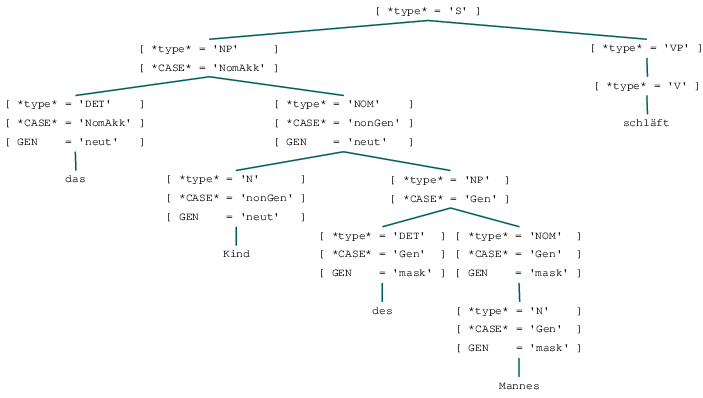

In [10]:
for t in parser.parse("das Kind des Mannes schläft".split()):
    display(t)

#### Folgendes sollte leer sein:

In [11]:
list(parser.parse("des Mannes schläft".split()))

[]

---
# Hausaufgaben

---
## Aufgabe 3: Unifikation II

#### Es seien wieder die Merkmalstrukturen aus Aufgabe 1 gegeben.

#### Unifizieren Sie:
- f1 mit f4
- f2 mit f3

#### Kontrollieren sie am Ende ihre Lösung zuerst mit Hilfe der interaktiven Fragen und überdenken Sie diese gegebenenfalls.

#### Mit der Ausführung der unteren beiden print-Statements können Sie abschließend die Lösung einsehen.

In [12]:
aufgabe(blatt10_3)

SingleChoice(children=(HTML(value='<h4 style="font-size:14px;">Unifizieren f1 und f4?</h4>', layout=Layout(jus…

SingleChoice(children=(HTML(value='<h4 style="font-size:14px;">Unifizieren f2 und f3?</h4>', layout=Layout(jus…

In [13]:
print(f1.unify(f4).__repr__())

None


In [14]:
print(f2.unify(f3).__repr__())

[Arbeit=[Ort=(1)['Muenchen'], Strasse='Oettingenstrasse'], Privat=[Ort->(1)], Strasse='Hauptstrasse']


---
## Aufgabe 4: Weniger Redundanz dank besonderer Merkmale

#### Beseitigen Sie die Redundanz in den lexikalischen Regeln (Zeilen 8 - 32) der folgenden Grammatik durch eine Typhierarchie (wo dies nötig ist). Achten Sie darauf, die Menge der akzeptierten Sätze weder zu verkleinern noch zu vergrößern!

#### Anzugeben sind die neuen Grammatikregeln, sowie Ihre Typhierarchie (z. B. in graphischer Form).

In [15]:
# Hierarchie der Fäle
case_hierarchy = {
    "nongen": ["nomakk", "dat"],
    "gendat": ["gen", "dat"],
    "nomakk": ["nom", "akk"],
    "nom": [],
    "gen": [],
    "dat": [],
    "akk": []
}

# Hierarchie der Geschlechter
gen_hierarchy = {
    "maskneut": ["mask", "neut"],
    "mask": [],
    "fem": [],
    "neut": []
}

In [16]:
redundant_grammar = """
S -> NP[*CASE*=nom] VP

NP[*CASE*=?y] -> DET[*GEN*=?x,*CASE*=?y] NOM[*GEN*=?x,*CASE*=?y]
NOM[*GEN*=?x,*CASE*=?y] -> N[*GEN*=?x,*CASE*=?y] NP[*CASE*=gen]
NOM[*GEN*=?x,*CASE*=?y] -> N[*GEN*=?x,*CASE*=?y]

DET[*GEN*=mask,*CASE*=nom] -> "der"
DET[*GEN*=maskneut,*CASE*=gen] -> "des"
DET[*GEN*=maskneut,*CASE*=dat] -> "dem"
DET[*GEN*=mask,*CASE*=akk] -> "den"

DET[*GEN*=fem,*CASE*=nomakk] -> "die"
DET[*GEN*=fem,*CASE*=gendat] -> "der"

DET[*GEN*=neut,*CASE*=nomakk] -> "das"

N[*GEN*=mask,*CASE*=nongen] -> "Mann"
N[*GEN*=mask,*CASE*=gen] -> "Mannes"
N[*GEN*=fem] -> "Frau"
N[*GEN*=neut,*CASE*=nongen] -> "Buch"
N[*GEN*=neut,*CASE*=gen] -> "Buches"

VP -> V NP[*CASE*=dat] NP[*CASE*=akk]
V -> "gibt" | "schenkt"
"""

In [17]:
CASE = HierarchicalFeature("CASE", case_hierarchy)
GEN = HierarchicalFeature("GEN", gen_hierarchy)
compiled_grammar = nltk.grammar.FeatureGrammar.fromstring(
    redundant_grammar, features=(CASE, GEN, TYPE)
)

In [18]:
pos_sentences = [
    "der Mann gibt der Frau das Buch",
    "die Frau des Mannes gibt dem Mann der Frau das Buch des Buches"
]

#### Testen Sie mit Ihren eigenen Negativbeispielen!

In [19]:
neg_sentences = [
    "des Mannes gibt der Frau das Buch",
    "Mann gibt der Frau das Buch",
    "der Mann gibt der Frau Buch",
    "der Frau gibt dem Buch den Mann",
    "das Buch der Mann gibt der Frau das Buch"
]

In [20]:
from IPython.display import display

def test_grammar(grammar, sentences):
    parser = nltk.parse.FeatureEarleyChartParser(grammar)
    
    for i, sent in enumerate(sentences, 1):
        print("Satz {}: {}".format(i, sent))
        results = parser.parse(sent.split())
        analyzed = False
        for tree in results:
            display(tree)  # print(tree)
            analyzed = True
        if not analyzed:
            print("Keine Analyse möglich")

Satz 1: der Mann gibt der Frau das Buch


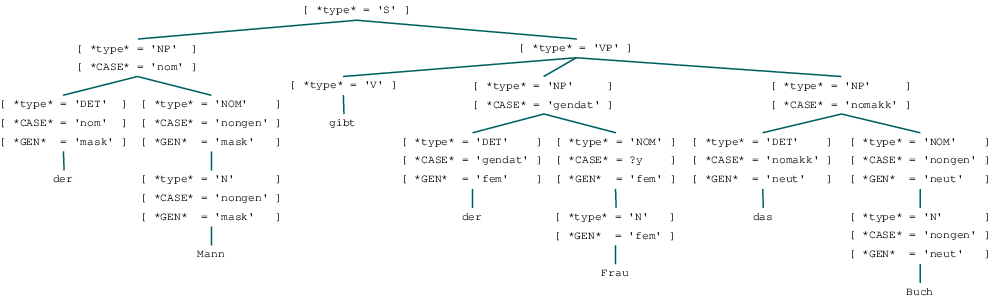

Satz 2: die Frau des Mannes gibt dem Mann der Frau das Buch des Buches


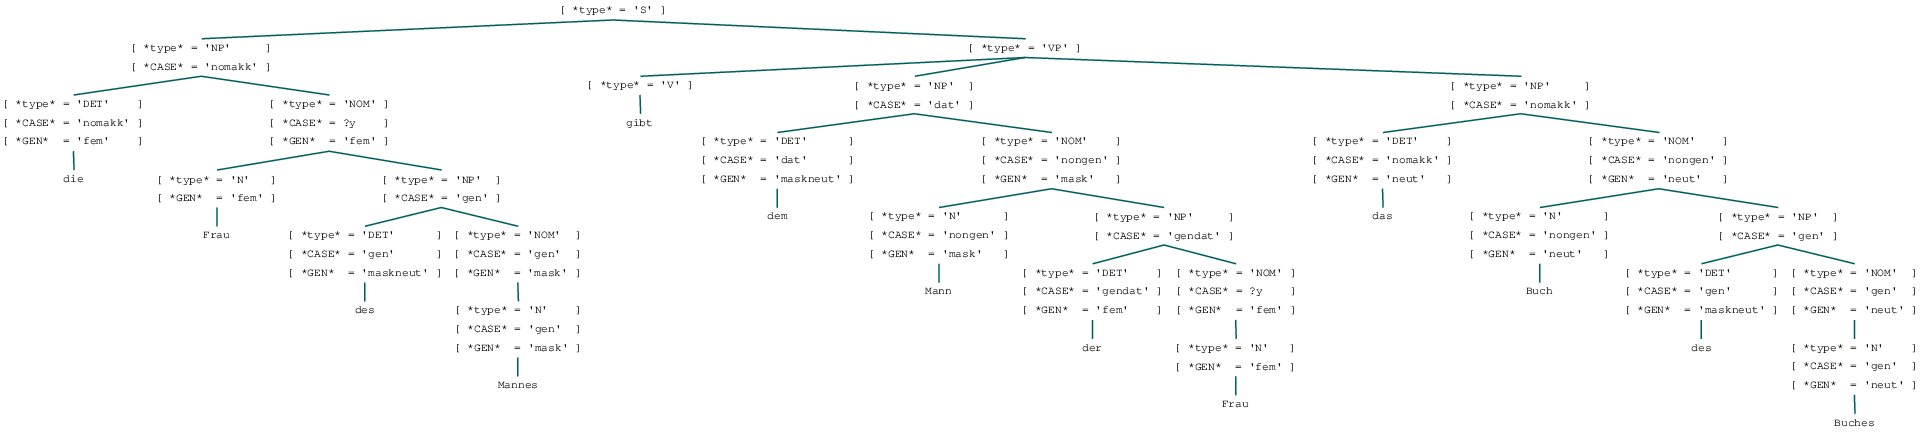

In [21]:
test_grammar(compiled_grammar, pos_sentences)

In [22]:
test_grammar(compiled_grammar, neg_sentences)

Satz 1: des Mannes gibt der Frau das Buch
Keine Analyse möglich
Satz 2: Mann gibt der Frau das Buch
Keine Analyse möglich
Satz 3: der Mann gibt der Frau Buch
Keine Analyse möglich
Satz 4: der Frau gibt dem Buch den Mann
Keine Analyse möglich
Satz 5: das Buch der Mann gibt der Frau das Buch
Keine Analyse möglich
